In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder,MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import shap # shap value
import joblib # to save model

### Introduction of the Topic
The topic is about dementia, we made a machine learning model to predict if someone is demented or nondemented. Dementia is a general term that describes a decline of brain capability caused by damage to brain cells. Dementia typically affects memory (like memory loss), communication, problem-solving, and emotional control. The condition tends to worse over time, impacting quality of life. 

We chose this topic because it’s important to have an early diagnosis. Early diagnosis can help with early manage for the symptoms and allows medical intervention that can slow down the disease. The model we made is a Binary Classification Model that classifies if someone is demented or nondemented.

### EDA

The dataset is obtained from Open Access Series of Imaging Studies (OASIS-2)
longitudinal collection of 150 subjects of 373 MRI data via ScienceDirect Jounal. The
dataset contains 15 columns:  
1. Subject ID: A unique identifier for each subject in the study.
2. MRI ID: The unique identifier for each MRI scan session of the subject. Subjects may have multiple MRI sessions.
3. Group: Classification of the subject into categories, such as "Demented", "Nondemented", or "Converted".
4. Visit: The number of the visit for the subject (e.g., first, second MRI session, etc.).
5. MR Delay: The number of days between the previous visit and current visit.
6. M/F: The gender of the subject, "M" = male and "F" = female.
7. Hand: The hand preference of the subject (e.g., "R" for right-handed).
8. Age: The age of the subject at the time of the MRI scan.
9. EDUC: The number of years of education the subject has completed.
10. SES: Socioeconomic status of the subject, a number indicating their level based on certain criteria.
11. MMSE: Mini-Mental State Examination score, a measure used to screen for cognitive impairment. The score ranges from 0 to 30, with higher scores indicating better cognitive function.
12. CDR: Clinical Dementia Rating, a scale used to quantify the severity of symptoms of dementia. The scale ranges from 0 (no dementia) to higher values indicating more severe dementia (e.g., 0.5, 1, 2).
13. eTIV: Estimated Total Intracranial Volume, representing the estimated volume of the brain and intracranial contents.
14. nWBV: Normalized Whole Brain Volume, representing the ratio of the subject’s brain volume relative to the estimated total intracranial volume.
15. ASF: Atlas Scaling Factor, a scaling factor used to normalize the brain volume based on the subject's intracranial volume.

In [3]:
dataframe = pd.read_excel("oasis_longitudinal_demographics.xlsx")

dataframe.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    float64
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(6), int64(4), object(5)
memory usage: 43.8+ KB


In [5]:
# Check Duplicate
dataframe.duplicated().sum()

0

Remove Identifier such as Subject ID and MRI ID

Remove Irrelevant Column such as Hand, Visit, and MR Delay

In [6]:
dataframe = dataframe.drop(columns=['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand'])
dataframe

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,Nondemented,M,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,Demented,M,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,Demented,M,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,Demented,M,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...
368,Demented,M,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,Demented,M,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,Nondemented,F,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,Nondemented,F,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


In [7]:
missing_values = dataframe.isnull().sum()
missing_values

Group     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

We considered imputing the SES feature since the missing value is just 5% of the data. However, considering that this model is intended for medical purposes, we wanted to keep the originality of the data. Additionally, the source data does not provide clear explanation about the standard for SES (socioeconomic status of the subject). As a result, since we don't have a clear understanding of what constitutes a high or low SES, it could lead to misinterpretation of the data. Therefore, we decided to drop the entire SES column to avoid any potential misunderstandings.

For MMSE (Mini-Mental State Examination score), this feature is important because related to mental state of the patient, so we must keep it. Because the missing value is just 0.5% of the data, so we drop the null value to maintain originality from data.

In [8]:
dataframe = dataframe.drop(columns=['SES'])
dataframe = dataframe.dropna(subset=['MMSE'])

dataframe

,Group,M/F,Age,EDUC,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,27.0,0.0,1986.550000,0.696106,0.883440
1,Nondemented,M,88,14,30.0,0.0,2004.479526,0.681062,0.875539
2,Demented,M,75,12,23.0,0.5,1678.290000,0.736336,1.045710
3,Demented,M,76,12,28.0,0.5,1737.620000,0.713402,1.010000
4,Demented,M,80,12,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...
368,Demented,M,82,16,28.0,0.5,1692.880000,0.693926,1.036690
369,Demented,M,86,16,26.0,0.5,1688.009649,0.675457,1.039686
370,Nondemented,F,61,13,30.0,0.0,1319.020000,0.801006,1.330540
371,Nondemented,F,63,13,30.0,0.0,1326.650000,0.795981,1.322890


In [9]:
categorical = []
numerical = []

for i in dataframe.columns:
    if 'int' in str(dataframe[i].dtype) or 'float' in str(dataframe[i].dtype):
        numerical.append(i)
    else:
        categorical.append(i)

print(f'Categorical: {categorical}')
print(f'Numeric: {numerical}')

Categorical: ['Group', 'M/F']
Numeric: ['Age', 'EDUC', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


In [10]:
# univariate analysis
dataframe[numerical].describe()

,Age,EDUC,MMSE,CDR,eTIV,nWBV,ASF
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,77.018868,14.611860,27.342318,0.287062,1489.870225,0.729514,1.193775
std,7.660864,2.877737,3.683244,0.371912,174.984615,0.037236,0.136546
min,60.000000,6.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,71.000000,12.000000,27.000000,0.000000,1358.475214,0.700178,1.098409
50%,77.000000,15.000000,29.000000,0.000000,1470.872944,0.728779,1.193169
75%,82.000000,16.000000,30.000000,0.500000,1597.768397,0.755691,1.291891
max,98.000000,23.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


In [11]:
# univariate analysis for categorical
for i in categorical:
    print(dataframe[i].value_counts(),'\n')

Group
Nondemented    190
Demented       144
Converted       37
Name: count, dtype: int64 

M/F
F    211
M    160
Name: count, dtype: int64 



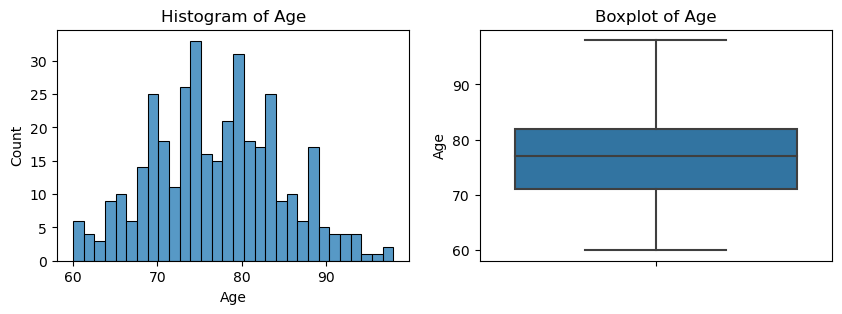

Age - Skewness: 0.13926116962824361
Age - Kurtosis: -0.4242486467102382


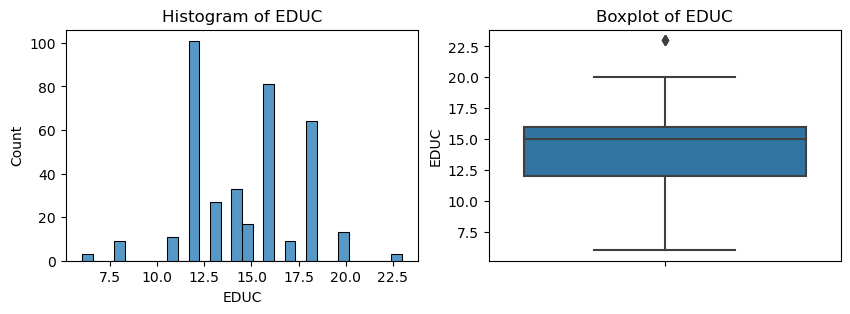

EDUC - Skewness: -0.03676055886330704
EDUC - Kurtosis: -0.008585478667662017


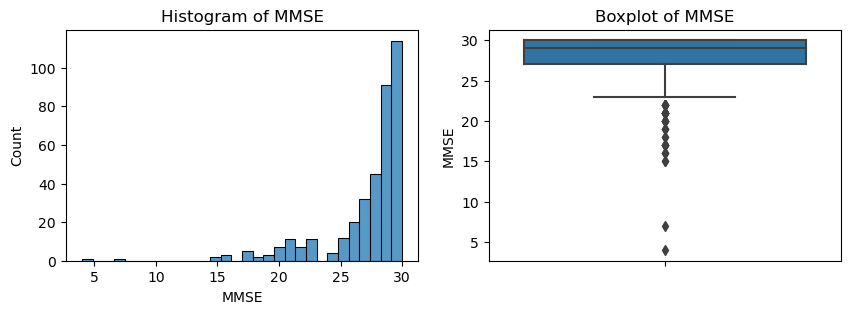

MMSE - Skewness: -2.366086132004125
MMSE - Kurtosis: 7.515849414549589


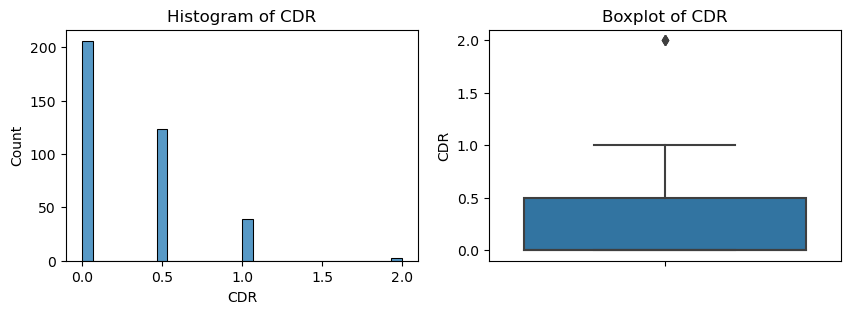

CDR - Skewness: 1.3483240874050229
CDR - Kurtosis: 2.3675135160897955


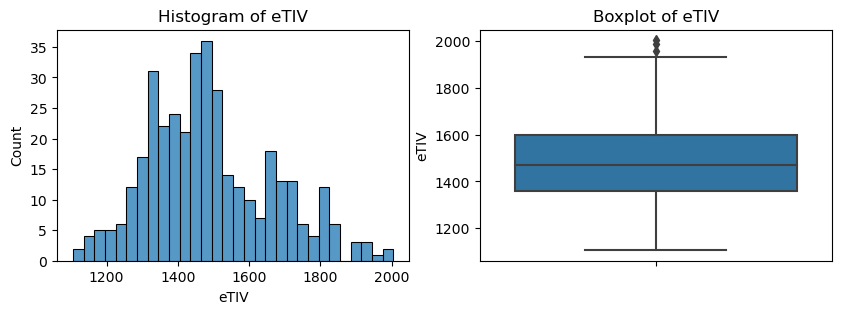

eTIV - Skewness: 0.5133141705431724
eTIV - Kurtosis: -0.11895192458512271


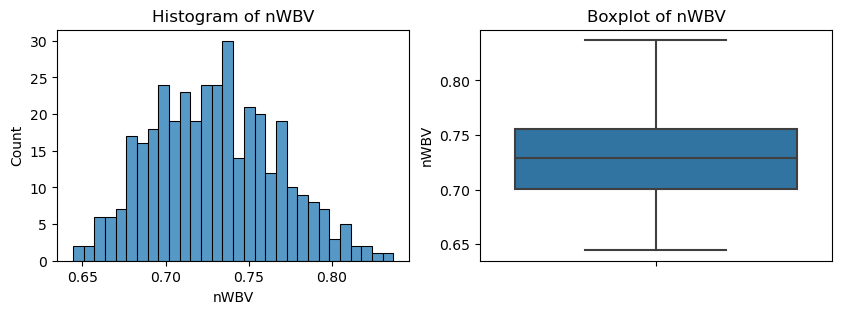

nWBV - Skewness: 0.23744322692565104
nWBV - Kurtosis: -0.4331101741404013


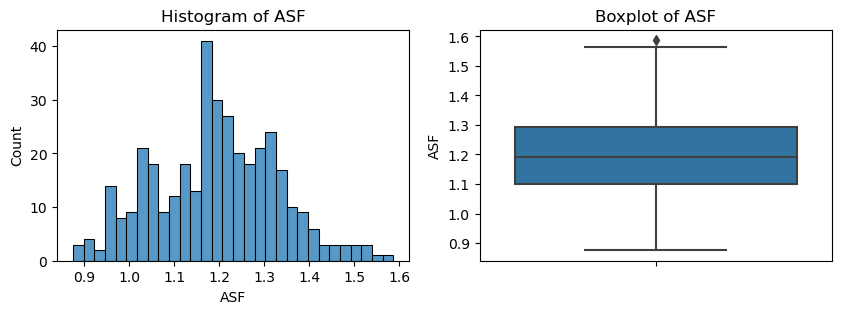

ASF - Skewness: 0.059810193689829864
ASF - Kurtosis: -0.23539340372367734


In [12]:
# distribution check
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        plt.figure(figsize=(10, 3))

        # Plot Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30)
        plt.title(f'Histogram of {col}')

        # Plot Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=dataframe[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        # Print skewness and kurtosis for each column
        print(f'{col} - Skewness: {dataframe[col].skew()}')
        print(f'{col} - Kurtosis: {dataframe[col].kurt()}')
        
check_distribution_outliers(dataframe[numerical], numerical)

The outliers in MMSE make sense, as some individuals may have mental disorders that result in low scores on the Mini-Mental State Examination (MMSE). Similarly, the outliers in CDR and eTIV are also justifiable, as they reflect real occurrences in patients.

Therefore, we don't need to address the outliers, as they are consistent with the nature of the data.

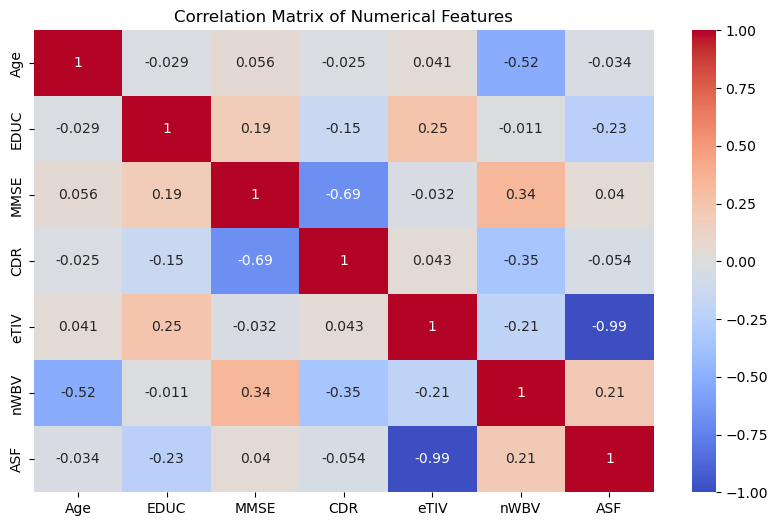

In [13]:
# bivariate analysis with correlation check
correlation_matrix = dataframe[numerical].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Some features like MMSE and CDR may show strong negative correlations, as these are related to cognitive decline (higher CDR and lower MMSE indicate dementia).

In [14]:
# bivariate analysis with anova
anova_results = {}
for col in numerical:
    demented_group = dataframe[dataframe['Group'] == 'Demented'][col]
    nondemented_group = dataframe[dataframe['Group'] == 'Nondemented'][col]
    converted_group = dataframe[dataframe['Group'] == 'Converted'][col]
    f_val, p_val = stats.f_oneway(demented_group.dropna(), nondemented_group.dropna(), converted_group.dropna())
    anova_results[col] = p_val
    
anova_results

{'Age': 0.046253608057754934,
 'EDUC': 3.737778561295075e-06,
 'MMSE': 1.5506362435108266e-38,
 'CDR': 3.475551150870005e-97,
 'eTIV': 0.5177187809371303,
 'nWBV': 2.883570028097228e-09,
 'ASF': 0.6794751607400034}

EDUC, MMSE, CDR, nWBV are significant to the y ('group'), because the p value is lower than 0.05.

##### EDA Results  
From the EDA, after we remove identifier column from dataset, we check the missing value. There are 19 missing values in Socioeconomic status (SES) and 2 missing values in Mini-Mental State Examination score (MMSE). There are no explanations about standard for SES. Therefore, we drop the whole SES column. While for MMSE, we drop the null value instead of imputation to maintain accuracy of the data. Additionally, there is no duplicate data in the dataset.  

For variable type, there are two categorical variables, which is Group and M/F. Meanwhile, the rest of the columns are all numerical variables. The demented group have lesser data than nondemented data with around 1:1.576 ratio. Nonetheless, this is still considered a balanced dataset.

From the histogram, we can conclude that none of the numerical columns arr normally distributed.  

For outliers, there are some outliers in numerical variable, but we ignore it, because they are justifiable and are expected to happen. Furthermore, we want to get an accurate model so capping or removing outlier will make the data bias.  

From the bivariate analysis with anova, the numerical columns with p value < 0.05 are considered to have a significant impact to the y (group). These significant columns are EDUC, MMSE, CDR, and nWBV

### Preprocessing

In [15]:
dataframe['Gender'] = dataframe['M/F'].apply(lambda x: 1 if x == 'M' else 0)

ord_enc = OrdinalEncoder(categories=[['Nondemented','Converted','Demented']])
dataframe['Group'] = ord_enc.fit_transform(dataframe[['Group']])

dataframe

,Group,M/F,Age,EDUC,MMSE,CDR,eTIV,nWBV,ASF,Gender
0,0.0,M,87,14,27.0,0.0,1986.550000,0.696106,0.883440,1
1,0.0,M,88,14,30.0,0.0,2004.479526,0.681062,0.875539,1
2,2.0,M,75,12,23.0,0.5,1678.290000,0.736336,1.045710,1
3,2.0,M,76,12,28.0,0.5,1737.620000,0.713402,1.010000,1
4,2.0,M,80,12,22.0,0.5,1697.911134,0.701236,1.033623,1
...,...,...,...,...,...,...,...,...,...,...
368,2.0,M,82,16,28.0,0.5,1692.880000,0.693926,1.036690,1
369,2.0,M,86,16,26.0,0.5,1688.009649,0.675457,1.039686,1
370,0.0,F,61,13,30.0,0.0,1319.020000,0.801006,1.330540,0
371,0.0,F,63,13,30.0,0.0,1326.650000,0.795981,1.322890,0


In [16]:
# Data split
x = dataframe[dataframe.columns.drop(['Group','M/F'])]
y = dataframe['Group']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)
print(x_train.shape,x_test.shape)

(296, 8) (75, 8)


In [17]:
# Data Scaling
for i in numerical:
    print(i, shapiro(dataframe[i]))

Age ShapiroResult(statistic=0.992691695690155, pvalue=0.06705545634031296)
EDUC ShapiroResult(statistic=0.939169704914093, pvalue=3.4529011594397474e-11)
MMSE ShapiroResult(statistic=0.7152780294418335, pvalue=1.1887444574464711e-24)
CDR ShapiroResult(statistic=0.7228413224220276, pvalue=2.2865492269542903e-24)
eTIV ShapiroResult(statistic=0.9741761684417725, pvalue=3.5423245208221488e-06)
nWBV ShapiroResult(statistic=0.9909431338310242, pvalue=0.022389663383364677)
ASF ShapiroResult(statistic=0.991696834564209, pvalue=0.03587514907121658)


Only the variable 'Age' is normally distributed, but the pvalue is so close to 0.05, As a result we use a robust scaler for all of the numerical data

In [18]:
rob_scaler = RobustScaler()

x_train[numerical] = rob_scaler.fit_transform(x_train[numerical])
x_test[numerical] = rob_scaler.transform(x_test[numerical])

y train is categorical, so it doesn't need to be scaled

### Train Model

##### GBM Model

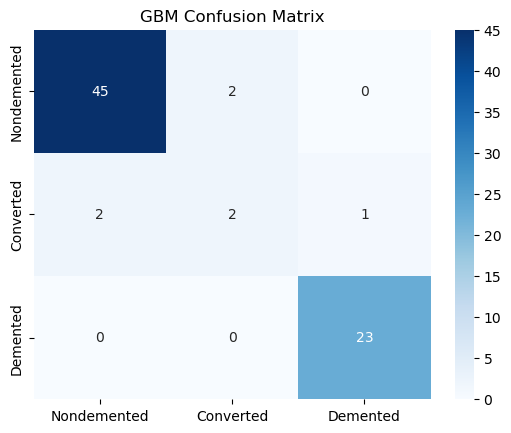

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        47
         1.0       0.50      0.40      0.44         5
         2.0       0.96      1.00      0.98        23

    accuracy                           0.93        75
   macro avg       0.81      0.79      0.79        75
weighted avg       0.93      0.93      0.93        75



In [19]:
# Initialize and train the GBM model
gbm_model = GradientBoostingClassifier(random_state=123)
gbm_model.fit(x_train, y_train)

# Predicting and evaluating the GBM model
gbm_predictions = gbm_model.predict(x_test)

# Confusion Matrix for GBM
sns.heatmap(confusion_matrix(y_test, gbm_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Nondemented','Converted','Demented'], yticklabels=['Nondemented','Converted','Demented'])
plt.title("GBM Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, gbm_predictions))

Since we don't want any False Negative predictions, therefore we need to focus on RECALL metrics. For example: a person with dementia is predicted to be nondementia, it could lead to unwanted consequences due to wrong predictions.  

From the classification report, the macro recall is 0.79, this means that 79% of the actual positive data is predicted positive by the model, the remaining 21% is predicted to be negative. As a result, we can conclude that the model is insufficient for this case. The macro precision is 0.81, this means that 81% of the positive prediction is actual positive.  

#### Hyperparameter Tuning With GridSearchCV

In [117]:
parameters_gbm = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

gbm_model_hyper = GradientBoostingClassifier(random_state=123)
gbm_model_hyper = GridSearchCV(gbm_model_hyper,
                               param_grid=parameters_gbm,
                               scoring='recall_macro',
                               cv=5)

gbm_model_hyper.fit(x_train, y_train)
print('Tuned Hyperparameters: ', gbm_model_hyper.best_params_)
print('Accuracy: ', gbm_model_hyper.best_score_)


Tuned Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy:  0.7430213464696223


In [28]:
# Train the data using best parameter
gbm_model_hyper_best = GradientBoostingClassifier(learning_rate=0.1,
                                                  max_depth=3,
                                                  n_estimators=100,
                                                  subsample=0.8)
gbm_model_hyper_best.fit(x_train, y_train)
gbm_predictions_best = gbm_model_hyper_best.predict(x_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, gbm_predictions_best))
print("Confussion matrix:\n", confusion_matrix(y_test, gbm_predictions_best))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        47
         1.0       0.67      0.40      0.50         5
         2.0       0.96      1.00      0.98        23

    accuracy                           0.95        75
   macro avg       0.86      0.79      0.82        75
weighted avg       0.94      0.95      0.94        75

Confussion matrix:
 [[46  1  0]
 [ 2  2  1]
 [ 0  0 23]]


After performing hyperparameter tuning, the macro precision is increased from 0.81 to 0.86, meanwhile the recall score still remains the same as before. The increased precision made the f1-score rise from 0.79 to 0.82. Because we are focused on the recall score, this model is inadequate at avoiding False Negative Predictions.  
  
Starting with the prediction of class 0 or NonDemented, the precision score is 0.96, the recall score is 0.98 and f1-score is 0.97. These results demonstrate that the model performs exceptionally in classifying Class 0. The recall score indicates that 98% of the actual positive cases are correctly identified as positive. The precision score means that 96% of the positive predictions made by the model are correct.
  
In class 1 or Converted, the model performance isn't optimal, which can be seen from the recall score, which is 0.40. This means that only 40% of the actual positive instances are correctly predicted by the model. Meanwhile, of the positive predictions made by the model, only 67% are actually positive. This issue may also be influenced by the very small amount of data in Class 1, with only 37 total instances and just 5 instances in the test set.

In class 2 or Demented, the model performance is at its peak, with a recall score of 100%, meaning all positive instances of demented data are correctly predicted as positive. Furthermore, 96% of the positive predictions made by the model are accurate, demonstrating that the model isn't just simply making random predictions.
  
Based on overall or macro average, the model's recall score is 0.79, meaning that 79% of the actual positive instances are successfully predicted as positive, leaving 21% of the positive instances missed. In addition, the precision score of 0.86 indicates that 86% of the instances predicted as positive are actually positive. Hence, the macro F1-score is 0.82. 

In conclusion, despite hyperparameter tuning, the proposed model is not yet suitable for deployment, as the macro precision, F1-score, and particularly the recall score, all remain below 0.9.


#### Base Line Model (SVM)

In [24]:
# Train the Model
svm_model = SVC(kernel='linear', probability=True)

svm_model.fit(x_train, y_train)

# Use model for prediction
y_pred = svm_model.predict(x_test)

#### Evaluate The Model

In [25]:
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        47
         1.0       1.00      0.20      0.33         5
         2.0       0.96      1.00      0.98        23

    accuracy                           0.95        75
   macro avg       0.97      0.73      0.76        75
weighted avg       0.95      0.95      0.93        75

[[47  0  0]
 [ 3  1  1]
 [ 0  0 23]]


From the macro recall, the SVM model demonstrates a relatively low recall score of 0.73, meaning that only 73% of the actual positive instances are correctly identified. On the other hand, its precision score is excellent at 0.97, indicating that 97% of the instances predicted as positive are indeed actual positives.

#### Hyperparameter Tuning With GridSearchCV

In [113]:
# Define a parameter grid to tune C and kernel
param_grid = {'C': [0.1, 1, 10, 100], 
              'kernel': ['linear', 'rbf', 'poly'], 
              'gamma': ['scale', 'auto'],
              }

# Perform grid search with cross-validation (CV = 5)
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5, scoring='recall_macro')
grid.fit(x_train, y_train)

# Best parameters found by GridSearch
print(f"Best parameters: {grid.best_params_}")

# Use the best model to make predictions
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate the best model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale

After tuning, all of the macro performance scores are increased, such as precision at 0.9, or 90% of the positive predictions made are all actual positives, then the recall score is 0.85, hence, 85% of the actual positive predictions are successfully predicted positive by the model. Additionally, the f1-score is 0.87.  
  
After hyperparameter tuning, the baseline model shows impressive performance in predicting class 0 or NonDemented. It achieves a recall score of 0.98, meaning that 98% of the actual nondemented instances are correctly identified as positive. The precision score is 0.94, indicating that 94% of the instances predicted as positive are actually nondemented. As a result, the F1 score is 0.96, which is on par with the GBM model, demonstrating that the prediction for class 0 is performed very well.
  
In class 1 or Converted, the model exhibits a low recall score of 0.60, meaning that only 60% of the actual positive instances are correctly predicted as converted. The precision score is 0.75, indicating that 75% of the instances predicted as positive are indeed converted. This further demonstrates that the SVM model struggles with accurately predicting class 1.
  
In class 2 or Demented, the model achieves a recall score of 0.96, meaning that 96% of the actual demented instances are correctly predicted as demented. Surprisingly, the model has a precision score of 1.0, indicating that 100% of the positive predictions made by the model are correct, with no errors. This excellent performance results in a high F1-score of 0.98.

By macro average, the model achieves a recall score of 0.85, meaning that 85% of the actual positive instances are correctly predicted as positive. The precision score is relatively high at 0.90, indicating that 90% of the instances predicted as positive are indeed correct. As a result, the F1-score is 0.87.

In summary, the SVM with an RBF kernel, our baseline model, achieved the highest recall score in this project. This suggests it is the most effective model for dementia classification, outperforming the GBM model in identifying positive cases.

### Feature Analysis With SHAP

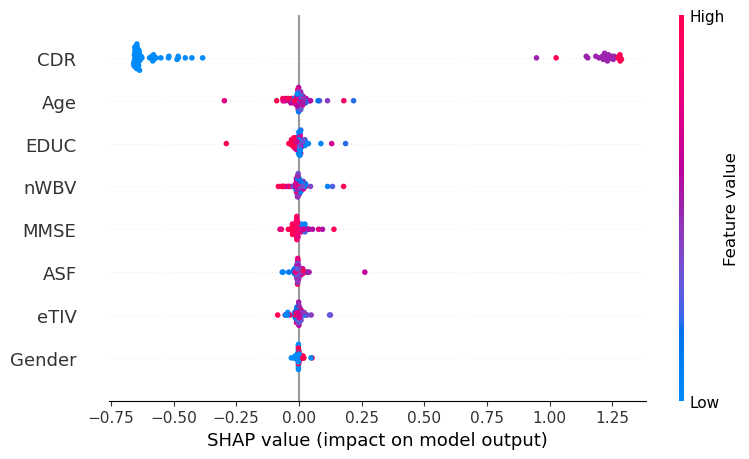

In [29]:
joblib.dump(gbm_model_hyper_best, 'model.pkl')

loaded_model = joblib.load('model.pkl')

# SHAP Explainer
# Define a predict function
def predict_fn(X):
    return loaded_model.predict(X)

# SHAP Explainer
explainer = shap.Explainer(predict_fn, x_test)
shap_values = explainer(x_test)


shap.summary_plot(shap_values, x_test)


From the shap summary plot above, we can conclude that:
1. CDR (Client Dementia Rating)  
    The most significant feature for the model (in this case, our proposed GBM model)  
    Low CDR values (blue) push predictions to lower values, while high CDR values (red) push predictions higher. This aligns with CDR's role in assessing dementia severity, where higher CDR values indicates more severe dementia
2. Age  
    The second most significant feature, but its impact is unclear, as both low and high age values cluster around the middle. Only a few data points show a more noticeable impact.
3. nWBV (Normalized Whole Brain Volume)  
    The third significant feature for the model, higher nWBV values (red) decrease the prediction, suggesting that better brain volume is associated with a lower likelihood of dementia.
4. EDUC (Years of Education)  
    More education (red) slightly reduces the prediction, it may act as a protective factor against dementia.
5. ASF (Atlas Scaling Factor)  
    Higher ASF values (red) increase the prediction. ASF is scaling factor to normalize the brain volume, so it's related to nWBV.
6. MMSE (Mini-Mental State Examination)  
    Higher MMSE scores (red) reduce the prediction, as better cognitive function is correlated with a lower likelihood of dementia.
7. eTIV (Estimated Total Intracranial Volume)  
    Minimal impact on the model. Larger eTIV values (red) slightly increase the predictions.
8. Gender (1: Male, 0: Female)
    Gender shows almost no significant impact on the model’s predictions. Only a few outlier female data points which slightly increase the predictions.

### Conclusion

Proposed model has worse performance than baseline model,  
but neither model is deployment-ready due to poor recall scores for the minority class.

Future Work:
1. Oversample minority classes using techniques like SMOTE or ADASYN.
2. Explore alternative models such as Random Forest or Neural Networks.
3. Increase dataset size to improve generalization.

Once optimized, these models can assist in the early detection of dementia, enabling timely interventions and improving patient outcomes.